# Анализ кластеров за 2016 год

In [1]:
import json
import numpy as np
from itertools import groupby
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO
from random import shuffle

%matplotlib notebook

In [2]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [3]:
def filter_words(text):
    words_list = text.split()
    newWords = [x for x in words_list if len(x) > 3]
    return " ".join(newWords)

# Загрузка новостей

In [4]:
news = []
with open('/data/kasandra/year/2016.all.normalized.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
news_map = {n.id: n for n in news}

# Удаление стоп-слов

In [5]:
words = []
for n in news:
    words.extend(n.content.split())
counts = Counter(words)
one_time = [k for k, v in dict(counts).items() if v == 1]
print("total words: %s" % (len(words) - len(one_time)))

total words: 19048075


In [6]:
one_time_words = set(one_time)

# Загрузка результатов кластеризации

In [7]:
news_labels = {}
with open('/data/kasandra/year/result/2016.300.kmeans.json', encoding="utf8") as f:
    news_labels = json.loads(f.read())

In [8]:
cluster_news = {}
for n_id, label in news_labels.items():
    if label in cluster_news:
        n_list = cluster_news[label]
        n_list.append(news_map[n_id])
    else:
        n_list = []
        n_list.append(news_map[n_id])
        cluster_news[label] = n_list

# Векторизация

In [9]:
news_constent = [filter_words(x.content) for x in news]

In [10]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), stop_words=one_time_words,
                                   max_df=0.5, min_df=2, norm='l2')

tfidf_matrix = tfidf_vectorizer.fit_transform(news_constent)
print("vocabulary size: %s" % len(tfidf_vectorizer.vocabulary_))

vocabulary size: 95475


# Количество новостей в кластерах

In [11]:
counts = Counter(news_labels.values())
counts.most_common(300)

[(21, 7121),
 (47, 1974),
 (38, 1368),
 (102, 1222),
 (67, 1144),
 (280, 1142),
 (10, 1024),
 (238, 966),
 (157, 950),
 (24, 922),
 (164, 891),
 (214, 876),
 (95, 874),
 (253, 874),
 (207, 849),
 (276, 823),
 (211, 775),
 (69, 759),
 (28, 754),
 (261, 737),
 (54, 723),
 (267, 712),
 (188, 708),
 (137, 705),
 (16, 694),
 (44, 688),
 (7, 681),
 (297, 675),
 (5, 654),
 (184, 654),
 (160, 619),
 (233, 616),
 (55, 614),
 (25, 612),
 (204, 603),
 (29, 589),
 (230, 571),
 (77, 550),
 (88, 548),
 (130, 544),
 (167, 544),
 (8, 529),
 (275, 518),
 (281, 514),
 (117, 511),
 (176, 510),
 (26, 508),
 (295, 505),
 (203, 504),
 (103, 500),
 (243, 497),
 (136, 493),
 (134, 491),
 (11, 486),
 (123, 483),
 (116, 481),
 (241, 474),
 (41, 471),
 (58, 469),
 (51, 465),
 (149, 455),
 (225, 451),
 (118, 450),
 (40, 447),
 (229, 444),
 (61, 439),
 (146, 437),
 (57, 434),
 (60, 434),
 (145, 428),
 (50, 422),
 (53, 422),
 (266, 401),
 (80, 399),
 (257, 393),
 (18, 389),
 (59, 383),
 (223, 380),
 (101, 379),
 (2

In [12]:
titles = [n.title for n in cluster_news[74]]
titles[:10]

['IPC расследует вынос флага России белорусами на открытии Игр',
 'Меценат, подаривший квартиру белорусу Фомочкину: Андрей совершил серьезный мужской поступок',
 'Установлена личность россиянина, подарившего белорусу Фомочкину квартиру',
 'Участник белорусской делегации рассказал, почему взял флаг России на церемонию открытия Паралимпиады',
 'Кому в России дарят квартиры: 5 примеров',
 'Поднявшему флаг России на Паралимпиаде вручили сертификат на квартиру в Москве',
 'Новые соседи поднявшего российский флаг белоруса приготовили ему тёплую встречу',
 'Петиция за отставку главы паралимпийского движения Белоруссии появилась в Сети',
 'Нил Кларк: на Паралимпиаде не место политике, если она не антироссийская',
 'Стало известно имя белоруса, пронесшего российский флаг на открытии Паралимпиады-2016']

# Сегментирование кластеров по дням

In [13]:
# 2016
start_year = 1451595600 * 1000
end_year = 1483217999 * 1000 + 1
day_millis = 24 * 60 * 60 * 1000

In [14]:
def segment_news(seg_news):
    segmented_news = {}
    for cur_day in range(start_year, end_year, day_millis):
        cur_news = [n for n in seg_news if n.date >= start_year and n.date <= cur_day]
        segmented_news[cur_day] = cur_news
    return segmented_news

# Вычисление отклонений для кластера

In [15]:
# year_centrid = np.array(tfidf_matrix.mean(axis=0))[0]
year_centrid = np.empty(tfidf_matrix.shape[1])
year_centrid.fill(1)

In [16]:
def day_cos(day_news):
    cos_news = {}
    for day, d_news in day_news.items():
        if len(d_news) > 0:
            content_day = [filter_words(x.content) for x in d_news]
            tfidf_day = tfidf_vectorizer.transform(content_day)
            day_centroid = np.array(tfidf_day.mean(axis=0))[0]
            cos_news[day] = 1 - spatial.distance.cosine(year_centrid, day_centroid)
        else:
            cos_news[day] = 0
    return cos_news

# Отрисовка графика

In [17]:
def plot_cos_centroid(cos_days, start_day, end_day, label):
    # plt.rcParams['figure.figsize'] = (20.0, 8.0)
    # plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)
    
    x = []
    y = []
    
    sorted_dates = sorted(list(cos_days.keys()))
    
    for ddd in sorted_dates:
        x.append(datetime.datetime.fromtimestamp(ddd/1000))
        y.append(cos_days[ddd])

    ax.plot(x, y, label = label)
    ax.legend(loc='upper right')
    fig.autofmt_xdate(rotation=60)
    fig.show()

# Вывод N первых новостей из кластера

In [18]:
def print_news(cl_news, n, cl_label):
    rand_news = []
    rand_news.extend(cl_news)
    shuffle(rand_news)
    
    print("cluster: %s, %s из %s новостей:" %(cl_label, n, len(cl_news)))
    for nn in rand_news[:n]:
        print("\t %s" % nn.title)

# Отображение сегментов

In [19]:
def compute_for_cluster(cl_news, cluster_number):
    segmented_news = segment_news(cl_news)
    cos_news = day_cos(segmented_news)
    
    print("График для кластера: %s" % (cluster_number))
    plot_cos_centroid(cos_news, start_year, end_year, cluster_number)
    print_news(cl_news, 30, cluster_number)
    print("----------------------")

# Фильтрация кластеров
убираем нулевой кластер и кластеры с маленьким количеством новостей

In [20]:
max_cluster_size = 700
mix_cluster_size = 600

In [21]:
medium_clusters = {k: v for k, v in cluster_news.items() if len(v) >= mix_cluster_size and len(v) <= max_cluster_size }
print("count clusters: %s" % len(medium_clusters))

count clusters: 11


# Графики

График для кластера: 16


<IPython.core.display.Javascript object>


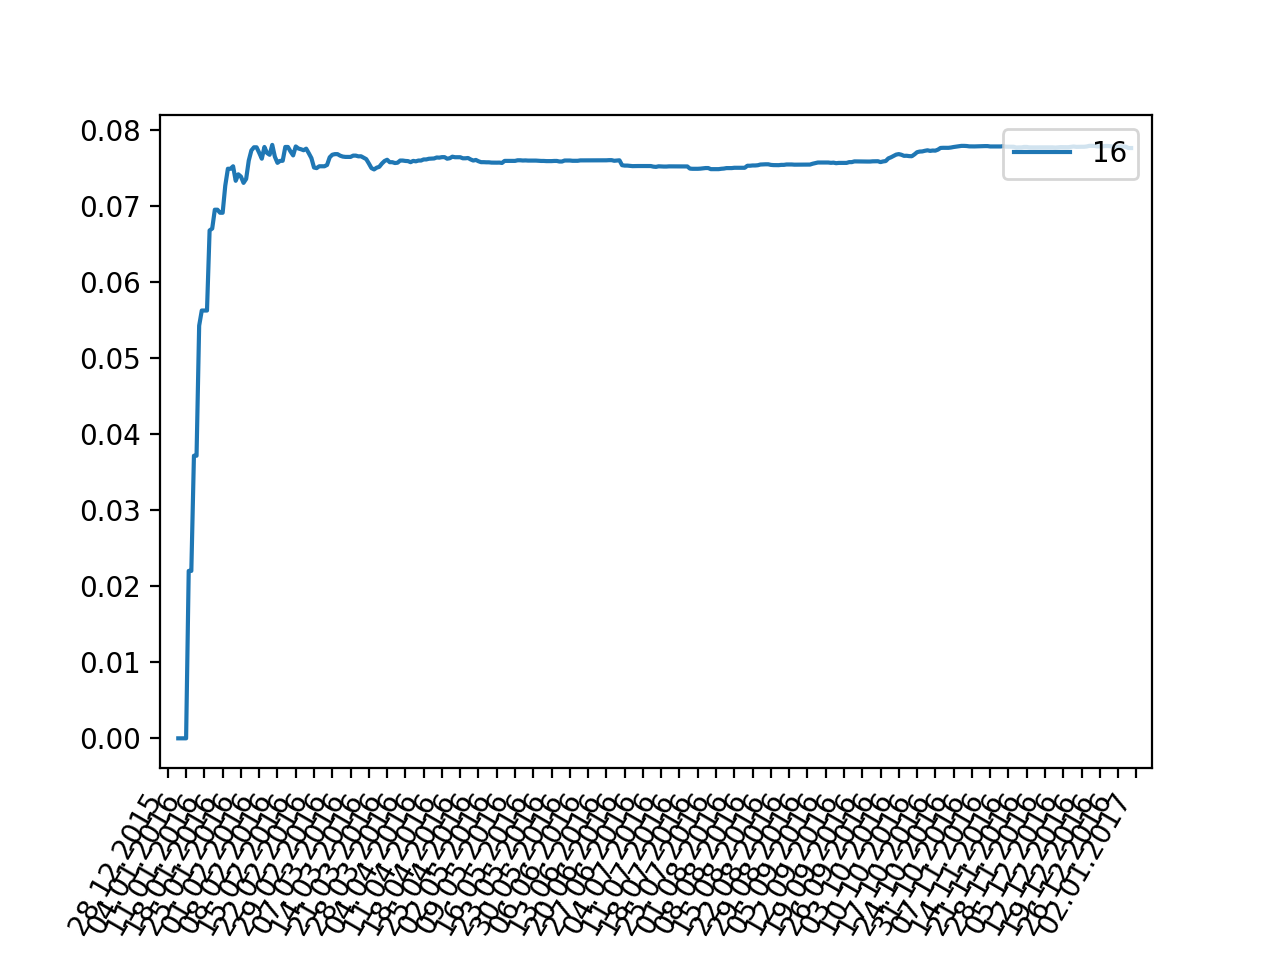

cluster: 16, 20 из 694 новостей:
	 Россия и США обсуждают освобождение "столицы ИГ"
	 Аналитики гадают, где Россия применит свою военную мощь после Сирии
	 Киселёв: американцы в Сирии не успевают и тормозят
	 Россия, Турция и Иран сообща будут бороться с терроризмом
	 Обама против новых антироссийских санкций
	 МИД РФ: угрозы США - это де-факто поддержка террористов
	 Туризм во время войны
	 В США назвали «загадкой» цели отправки военных из России на север Сирии
	 Спецпосланник ООН: переговоры по Сирии приостановлены до 25 февраля
	 Дума ратифицировала соглашение о бессрочном размещении авиагруппы в Сирии
	 Лондон обвинил Россию в разжигании гражданской войны в Сирии
	 Путин прокомментировал возможность предоставления Асаду убежища в России
	 NI составил топ-5 версий, почему Россия выводит войска из Сирии
	 Почему американцы боятся рассекретить сделку России и США по Сирии
	 Эрдоган: России не стоило принимать приглашение об операции в Сирии
	 Минобороны опровергло гибель шести российс

<IPython.core.display.Javascript object>


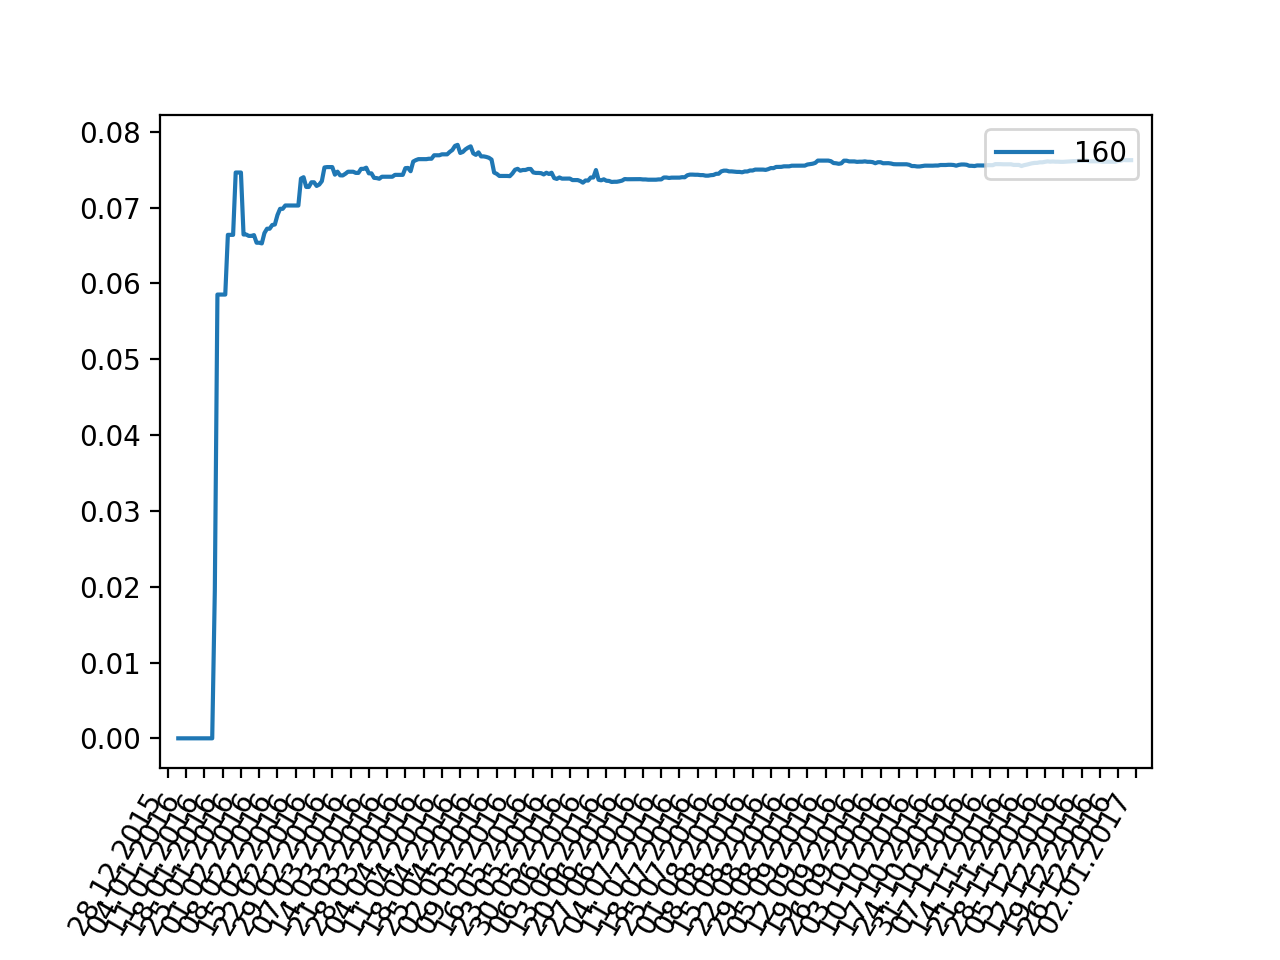

cluster: 160, 20 из 619 новостей:
	 Два самолета едва не столкнулись в небе над Москвой из-за трудностей перевода
	 Боевики выложили видео с захваченным в плен пилотом
	 Информация о падении самолета у берегов Мьянмы не подтвердилась
	 Трагедия 11 сентября: новые вопросы спустя 15 лет
	 Натовский самолет просканировал калининградское небо
	 Трамп предложил стрелять по российским истребителям
	 ВКС России получили второй новейший военно-транспортный Ил-76МД-90А
	 Пентагон возмущен: русский пилот лишил американских шпионов руля и ветрил
	 The Sun: Россия создаёт самолёт, способный уничтожить врага смертоносным лазером
	 Пушков поиронизировал над реакцией США на ситуацию с самолетами
	 Появилось видео падения сбитого в Сирии самолета
	 Пилот Су-27 катапультировался меньше чем в 100 метрах от земли
	 На «Адмирале Кузнецове» уже второе ЧП с истребителем. Кто виноват?
	 Эксперты 18 стран изучат новую российскую камеру для военных проверок
	 Мнение о F-35: нельзя рубить лес скальпелем, а опер

<IPython.core.display.Javascript object>


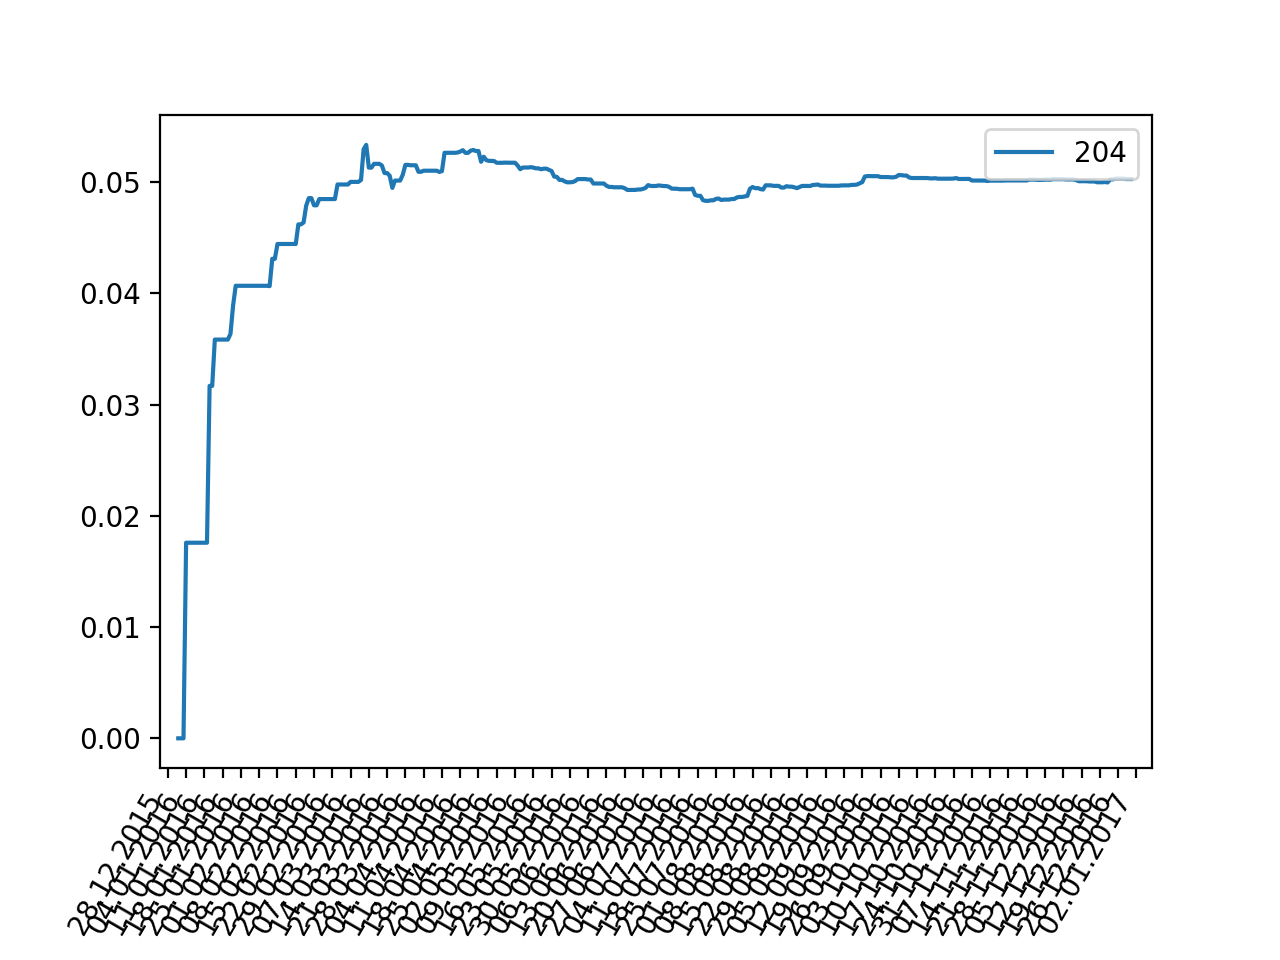

cluster: 204, 20 из 603 новостей:
	 Во Львове в многоэтажке прогремел взрыв
	 Взрыв прогремел в пакистанском храме: 30 человек погибли, более 100 ранено
	 В Ереване при взрыве в пассажирском автобусе погибли люди
	 Появилось первое видео с места взрывов в сирийском Тартусе
	 СМИ: В результате взрыва в турецкой Анталье пострадали несколько человек
	 В сети появилось видео взрыва на оружейном заводе в Азербайджане
	 СМИ: Число погибших при взрыве в Мексике возросло до 22 человек
	 Пострадавшего при взрыве на входе в метро "Коломенская" госпитализировали
	 В Нью-Джерси в районе железнодорожной станции прогремел взрыв
	 В Йемене в университете прогремел взрыв
	 СМИ сообщили о взрыве в Стамбуле
	 В Дагестане скончалась пострадавшая во время взрыва в банкетном зале
	 Число погибших при взрыве в коптском соборе в Каире возросло до 18
	 Число погибших в результате взрыва на рынке в Мексике возросло до 29 человек
	 Спасатели вновь обследуют место взрыва на "Войковской" из-за запаха газа
	 В мет

<IPython.core.display.Javascript object>


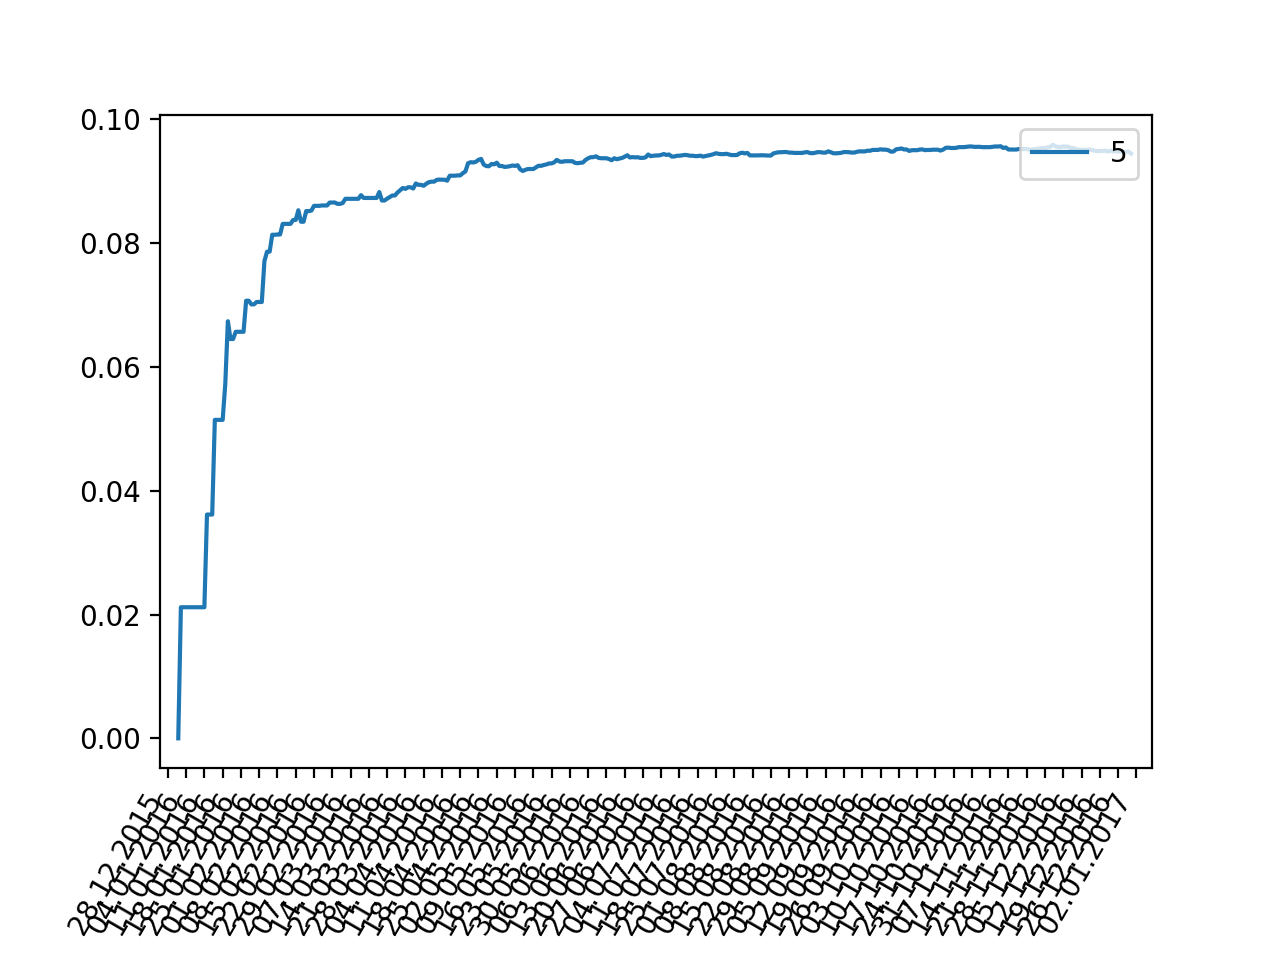

cluster: 5, 20 из 654 новостей:
	 Следком: пытавшийся сбежать в Казахстан Курзенков превышал полномочия
	 Житель Ростовской области приехал в Москву для «разборок» с Лениным
	 В Адыгее задержали группу избитых активистов «Гринпис»
	 В Москве задержаны пятеро разбойников из Мурманской области
	 Квантовый секс-скачок: на Кубани арестован глава секты
	 В Москве задержан член ОПГ, который 16 лет находился в розыске за похищения бизнесменов
	 В Иркутске раскрыто ограбление ювелирного салона на 20 млн рублей
	 Ополченцы поймали главарей подпольной группировки "Азова"
	 В Москве полиция задержала мужчину, угрожавшего убить свою мать
	 В Великобритании задержан 16-летний хакер
	 Полицейские инсценировали похищение, чтобы задержать заказчика преступления
	 Террористов, готовящих атаки на майских праздниках, задержали во время футбольного матча
	 На Кубани осудили водителя, шантажировавшего инспектора ДПС
	 Самую пожилую наркоторговку Бабу Нюру Ништяк отправили в колонию на 2 года
	 В Турции осв

<IPython.core.display.Javascript object>


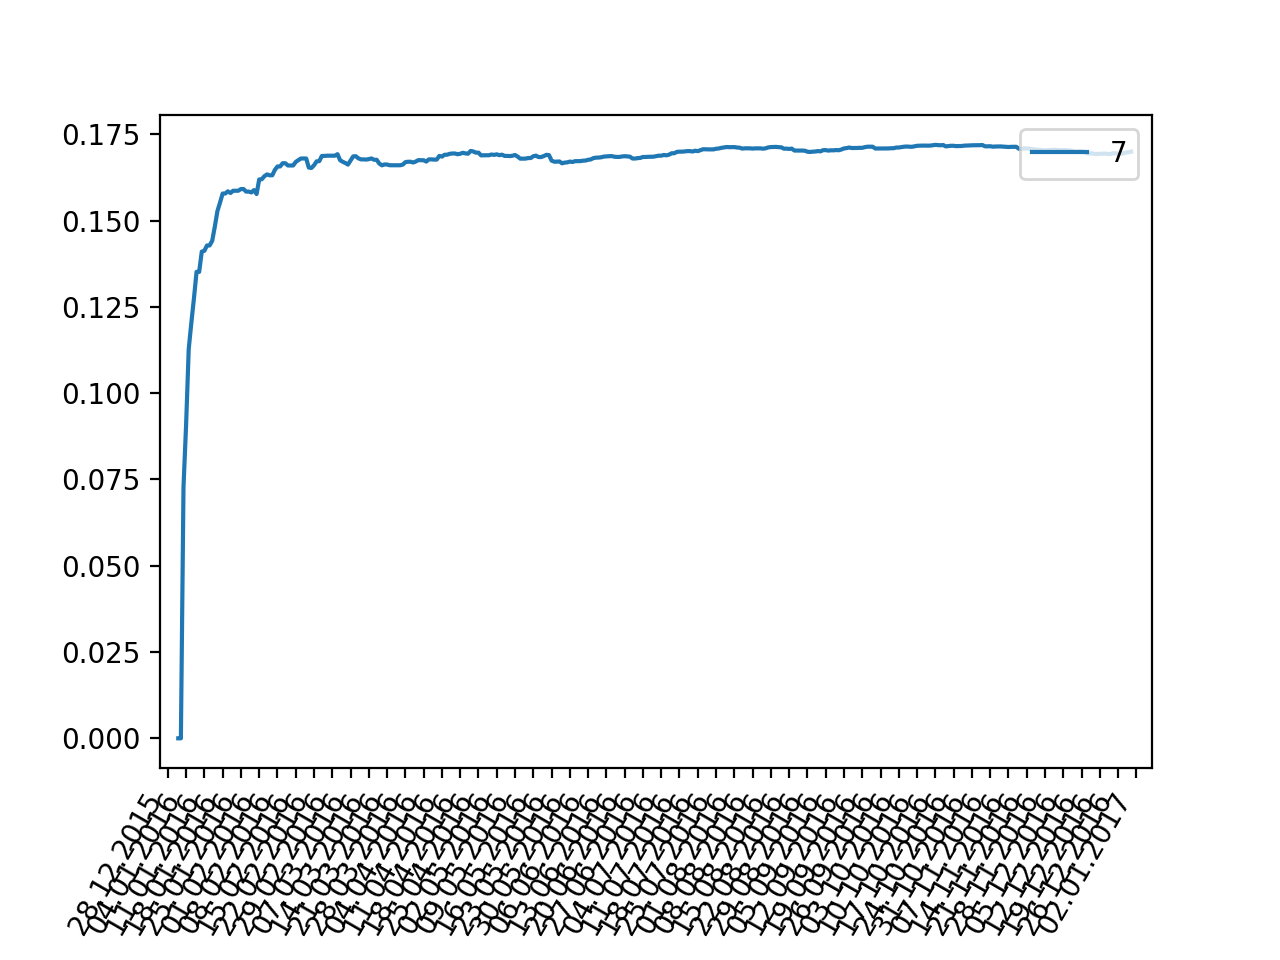

cluster: 7, 20 из 681 новостей:
	 «Для джихада мало клича "Аллаху акбар!"»
	 «Вечно молодым»: исчез ли комсомол четверть века назад
	 Период распада: последний декабрь Союза. 12 декабря 1991 года
	 «Настоящее зло во плоти»
	 Выступление Джулиана Ассанжа на медиафоруме в МИА "Россия сегодня"
	 Пробитые детские головы и оторванные ноги: новые антироссийские фальшивки
	 Ценностная революция: как расследования коррупции меняют мир
	 NI предложил альтернативный сценарий окончания холодной войны
	 ГКЧП и август 1991-го: что это было
	 Что в имени тебе таджикском?
	 Горбачев признал частичную ответственность за распад СССР
	 Секретарь горкома КПРФ Самары сменил фамилию на Сталин для поднятия дисциплины
	 Матвиенко отказалась мириться с притеснением русских за рубежом
	 «Если надо, то мы пальцем будем подтираться»
	 Человек, споривший со Сталиным
	 «Трехсотлетняя монархия. Раз — и нет ее»
	 Демократия приходит и уходит, а монархия остается
	 Евгений Евтушенко: «Прощай, наш красный флаг... С Кр

<IPython.core.display.Javascript object>


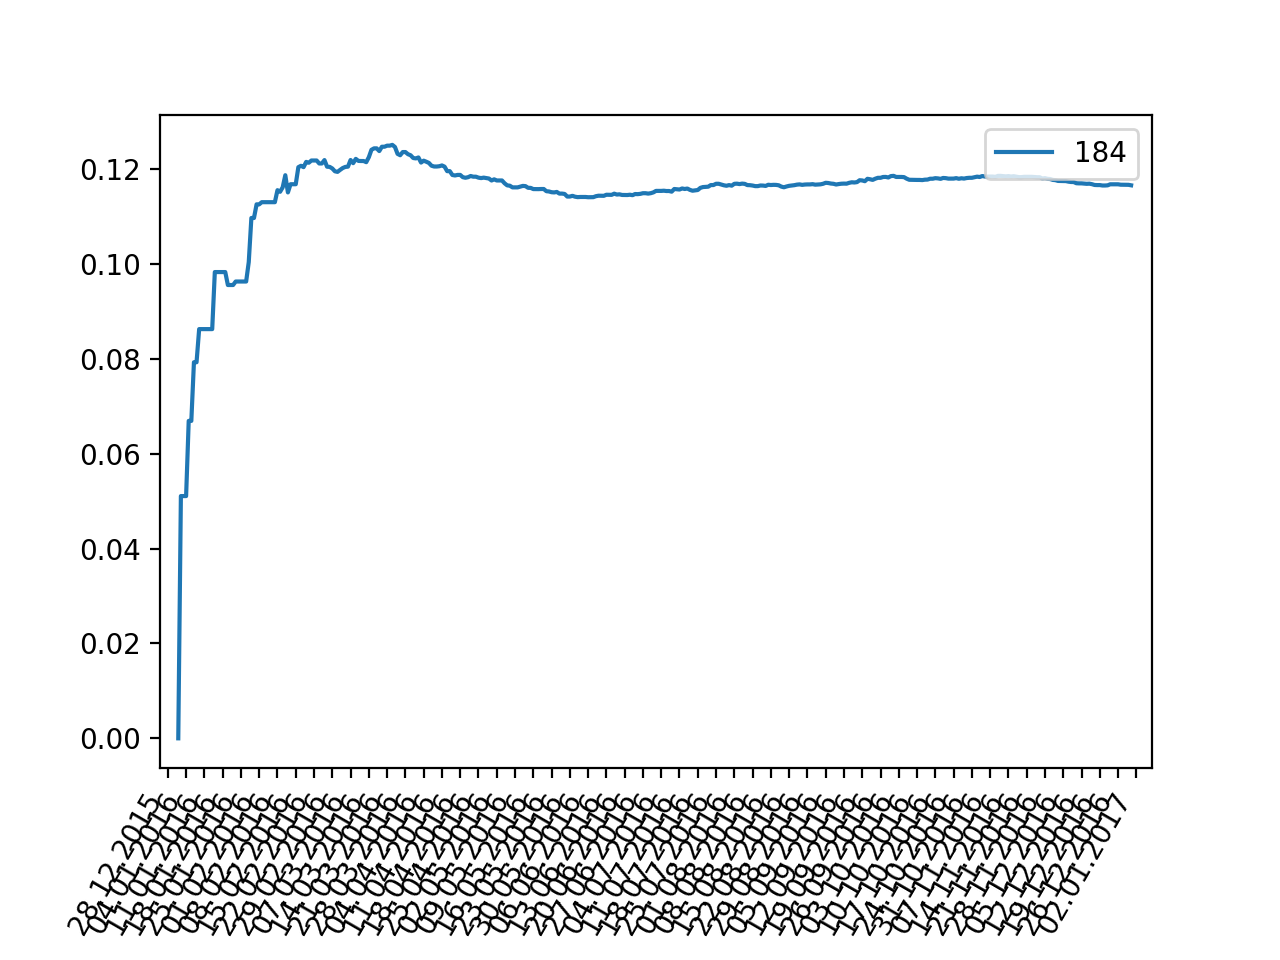

cluster: 184, 20 из 654 новостей:
	 Отбеливание кожи посчитали опасным для здоровья
	 Ухудшение памяти назвали результатом подавления воспоминаний
	 Найден простой способ улучшения памяти
	 Неопределенность оказалась для человека мучительней боли
	 Ученые рассказали, какая продолжительность рабочей недели делает человека счастливым
	 Шесть признаков диабета, на которые мы часто не обращаем внимания
	 Ученые: даже незначительный лишний вес может сократить срок жизни
	 Иглы, банки, порошки
	 Дыхание человека способно влиять на страх и память
	 Необъяснимые торнадо обеспокоили ученых
	 Зависимость от смартфона связали с жадностью и распущенностью
	 Ученые попытаются "воскресить" мертвый мозг при помощи белков
	 Человечество попало в нейросети
	 Создана интерактивная карта развития эмбриона
	 Ай да Трамп! Ай да сукин сын! Почему он победил назло всем прогнозам
	 Дружба с «бывшими» оказалась губительной для здоровья
	 Долина биотехнологий: почему Марка Цукерберга не испугал провал Theranos


<IPython.core.display.Javascript object>


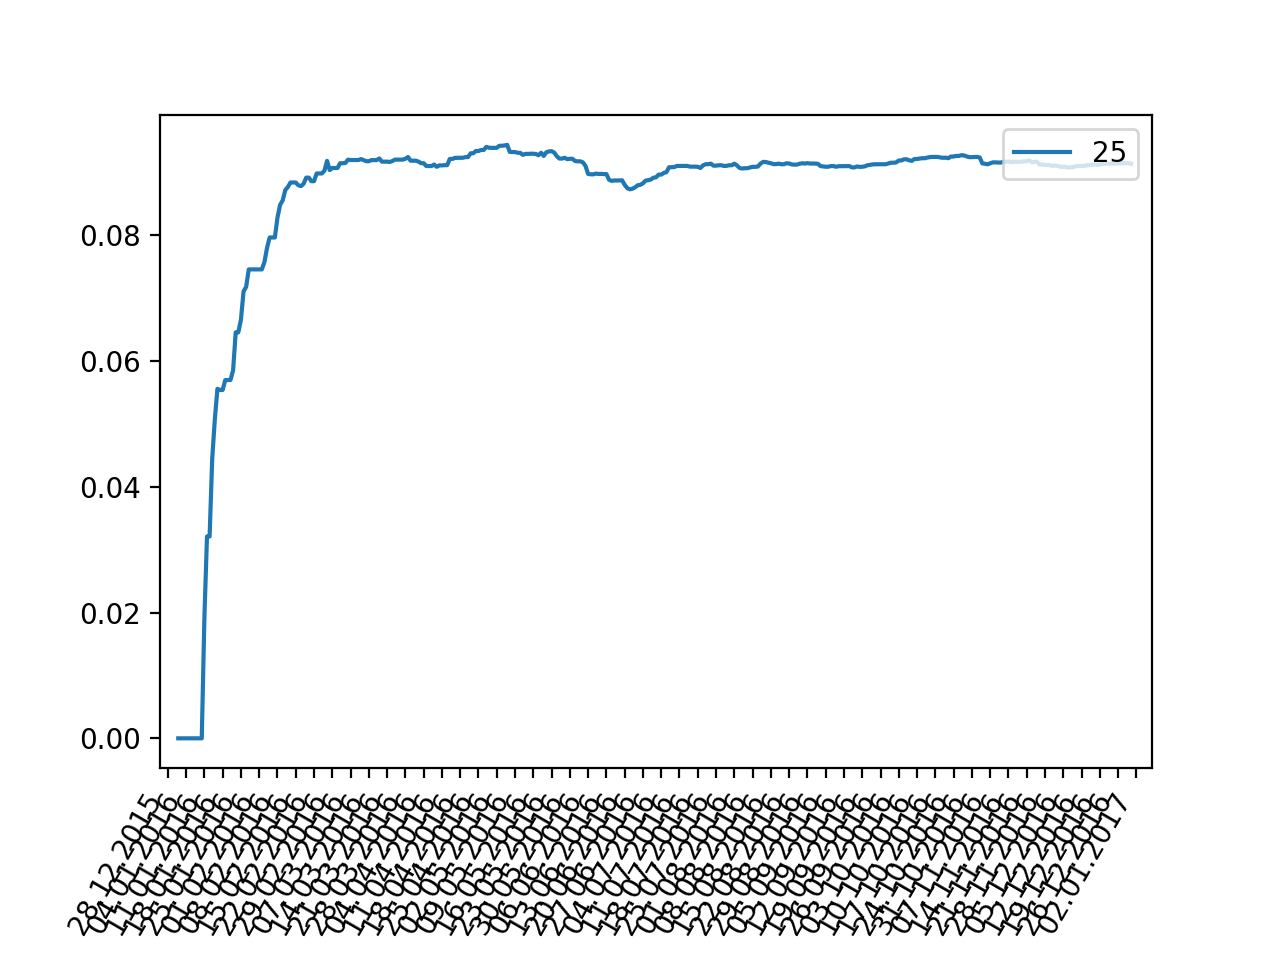

cluster: 25, 20 из 612 новостей:
	 Актёр Шайа Лабаф женился на звезде "Нимфоманки", которую зверски избил год назад
	 Путин не знает, что ДиКаприо хочет его сыграть
	 Тест: Сколько в вас Алексея Панина, когда вы перепили?
	 Каким мы помним дядю Женю
	 Станислав Садальский: Я получаю пенсию не за то, что снимался в кино, а за то, что работал в «Экпресс-газете», сестре «КП»
	 Актёр Эдди Мёрфи стал отцом в девятый раз
	 Звезда сериалов Юрий Батурин госпитализирован с острыми болями
	 Дочь Абдулова объяснила, почему не ходила на могилу отца
	 Актер Стивен Сигал получил российское гражданство
	 Госпитализирован актер Вячеслав Шалевич
	 Девушка написала Марату Башарову в Интернете, а теперь ждет от него ребенка
	 Марат Башаров впервые показал маленького сына
	 Рассела Кроу оправдали за плевок в певицу Азалию Бэнкс
	 Друзей Гарри Поттера не приняли в Гриффиндор
	 Умер 49-летний актер из "Усатого няня" и "Ералаша"
	 Тому Крузу угрожают убийством
	 Трамп удалил твит с критикой актёра "Гамильтон

<IPython.core.display.Javascript object>


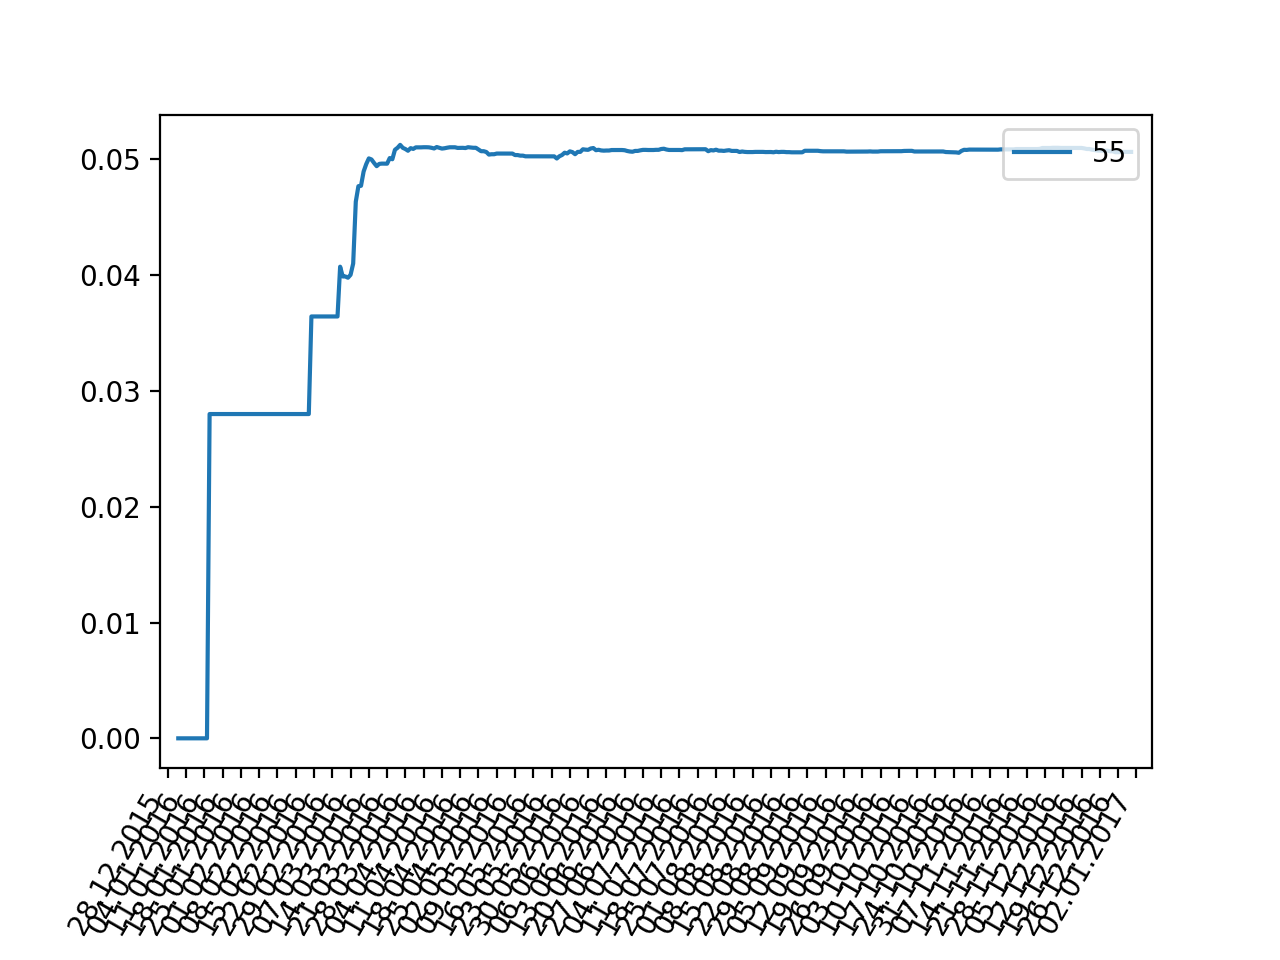

cluster: 55, 20 из 614 новостей:
	 Ляшко назвал встречу Савченко с главами ДНР и ЛНР госизменой
	 Савченко заявила, что администрация Порошенко готовит на нее покушение
	 Савченко вместо Бута и Ярошенко: версии обмена
	 Савченко ответила на обвинения в связях с ДНР и ЛНР
	 Савченко решила, что должна стать диктатором Украины
	 Тень Жанны д’Арк, или жук в муравейнике
	 Порошенко предложили лишить Савченко звания героя Украины
	 Порошенко предложил Савченко провести встречи с европейскими лидерами
	 Савченко назвала Раду базаром, а депутатов - ленивыми школьниками
	 Надежда Савченко создает собственную "Руну" с простым народом
	 Консулы Украины забрали Веру Савченко с КПП
	 Надежда Савченко впервые выступила в ПАСЕ
	 Надежда Савченко вывела семьи военнопленных на "новый Майдан"
	 Суд снял с Савченко обвинение в обстреле мирных жителей
	 Проблески Надежды: как много вы знаете о Савченко?
	 Маркин: дело Савченко сопровождалось и закончилось ее "шоу"
	 Штурман украинских ВВС Савченко намети

<IPython.core.display.Javascript object>


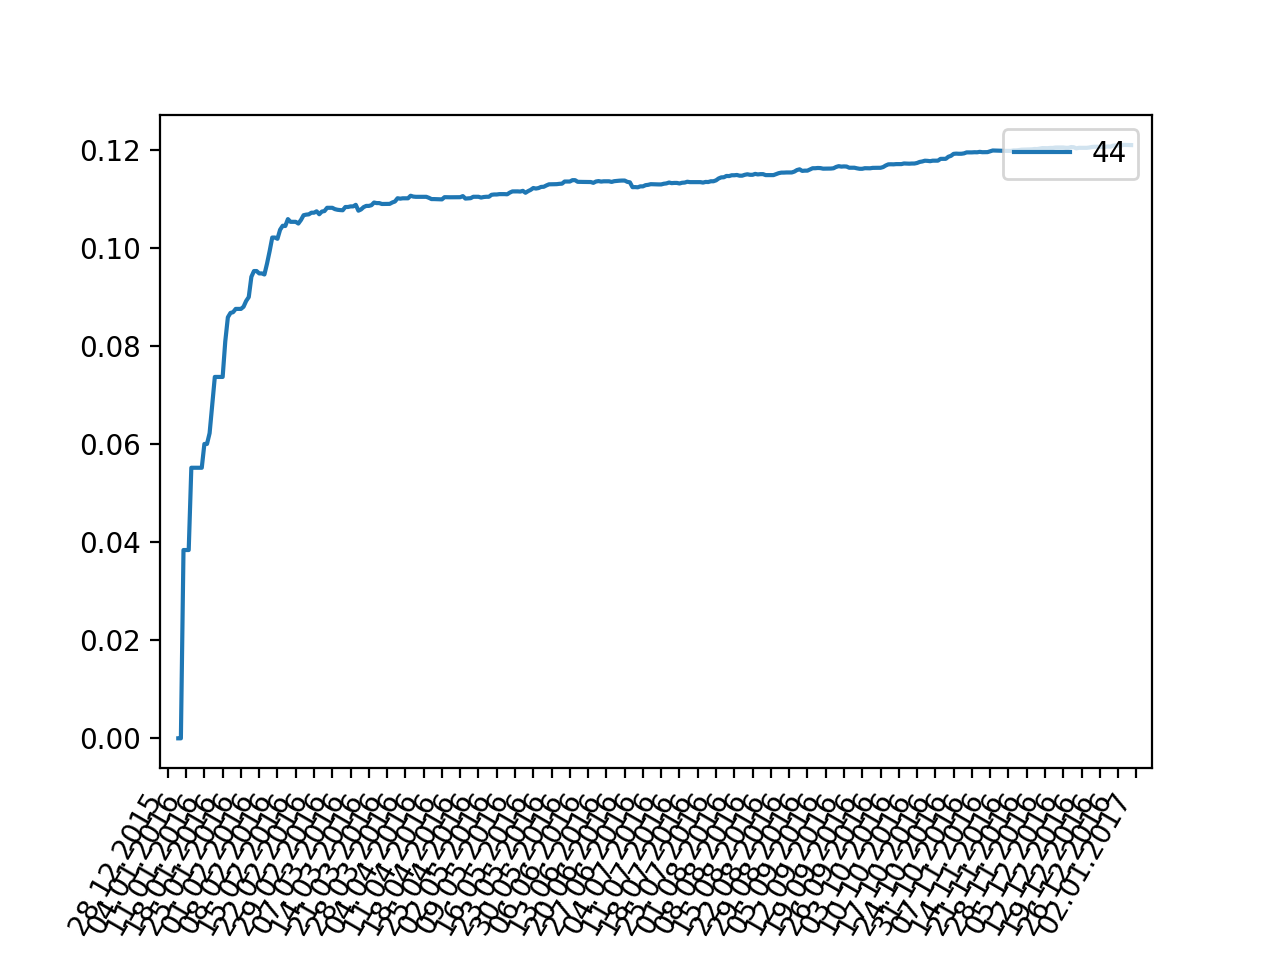

cluster: 44, 20 из 688 новостей:
	 Налог на Alibaba: правительство нашло способ помочь российским ретейлерам
	 «Путинка» выпала из десятки самых продаваемых водок в России
	 В Россельхознадзоре рассказали, почему не допускают турецкие фрукты на рынок РФ
	 Итальянский шеф-повар раскритиковал качество российских макарон
	 Попытка отбелить
	 Сила Siberica: как Андрей Трубников захватил рынок дешевой косметики
	 Вот это фрукт: турецкие апельсины пустили в Россию
	 Россия разрешит ввоз цитрусовых, персиков и слив из Турции
	 Минпромторг предложил ограничить права ретейлеров на продажу алкоголя и табака
	 Greeder.ru в тренде: как получить максимальную выгоду от "Черной пятницы"
	 Пять вещей, на которых экономят россияне в кризис
	 Белоруссия отправила в Россию пять годовых урожаев грибов и яблок
	 Россия запретила поставки салата из Турции
	 Поставки пива из России на Украину выросли втрое вопреки эмбарго
	 Forbes о санкциях: Россия может жить и без Европы
	 Купить кефир как у Путина? Запрос

<IPython.core.display.Javascript object>


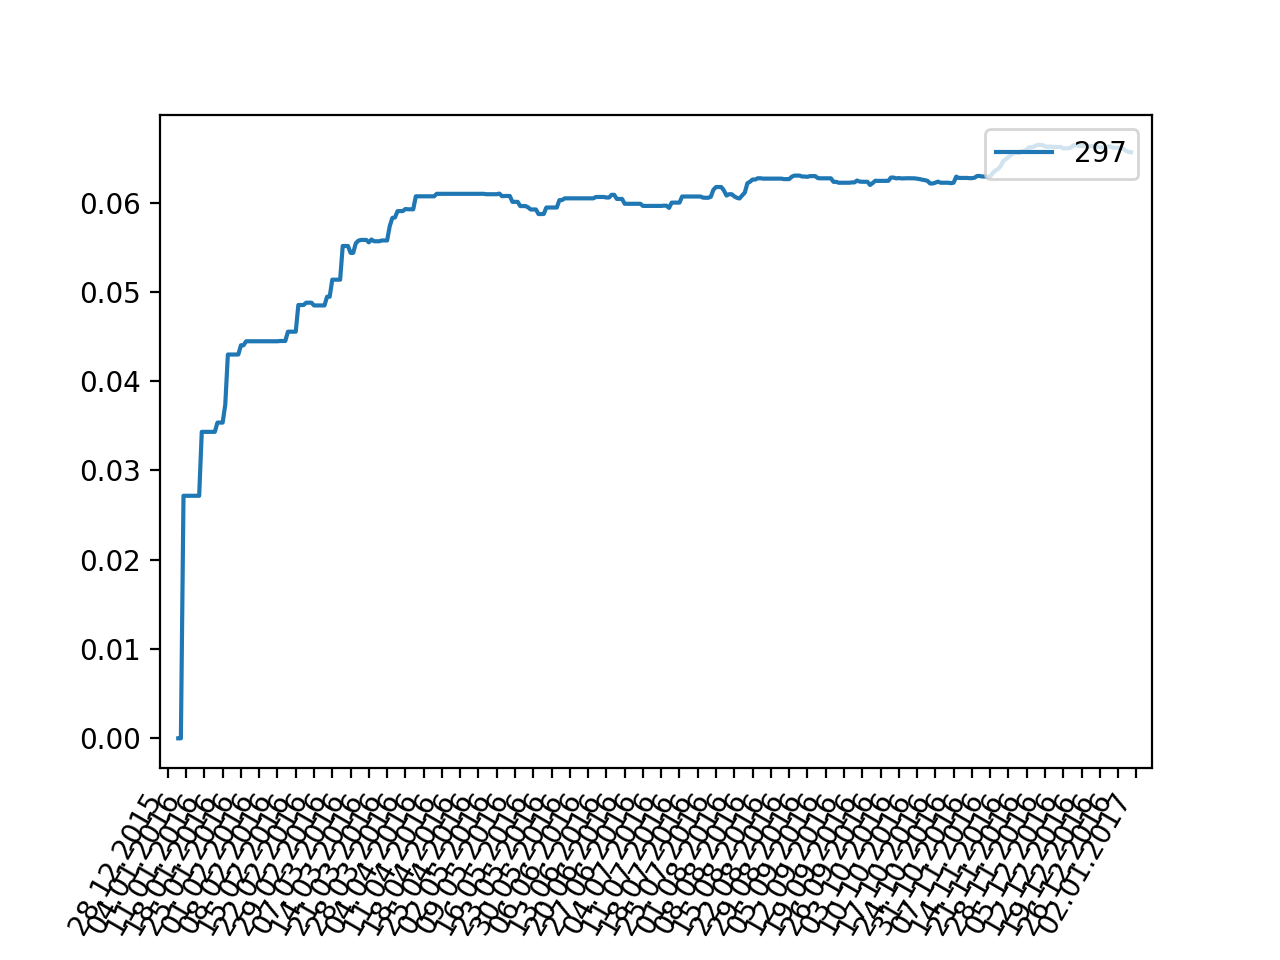

cluster: 297, 20 из 675 новостей:
	 Трамп и Обама рассказали об итогах встречи в Белом доме
	 Трамп обещает поладить со всеми странами, которые хотят поладить с США
	 Белый дом США не увидел криминала в сжигании флага своей страны
	 Рози О’Доннелл, назвавшая Бэррона Трампа аутистом, извинилась
	 Как усмирить Трампа: избранного президента США назвали пешкой
	 Forbes: Зять Трампа завоевал для него Белый дом
	 Трамп устроил не всех: в США запахло майданом
	 Телеведущая извинилась перед Меланией Трамп за слова о болезни ее сына
	 «Антонов» предложил Трампу свой самолет в качестве борта номер один
	 Супруга Трампа подала в суд на журналиста
	 Трамп назвал пресс-секретаря Белого дома "глупым парнем"
	 В Гватемале сожгли чучело Трампа, чтобы отпугнуть злых духов
	 Комик-мусульманин пошутил над сыном Трампа, сидящим рядом с ним в самолёте
	 Почему публичные туалеты на улицах Китая носят имя Трампа
	 Телеведущая рассказала о попытках Трампа подкупить журналистов перед выборами
	 Трамп - это бол

<IPython.core.display.Javascript object>


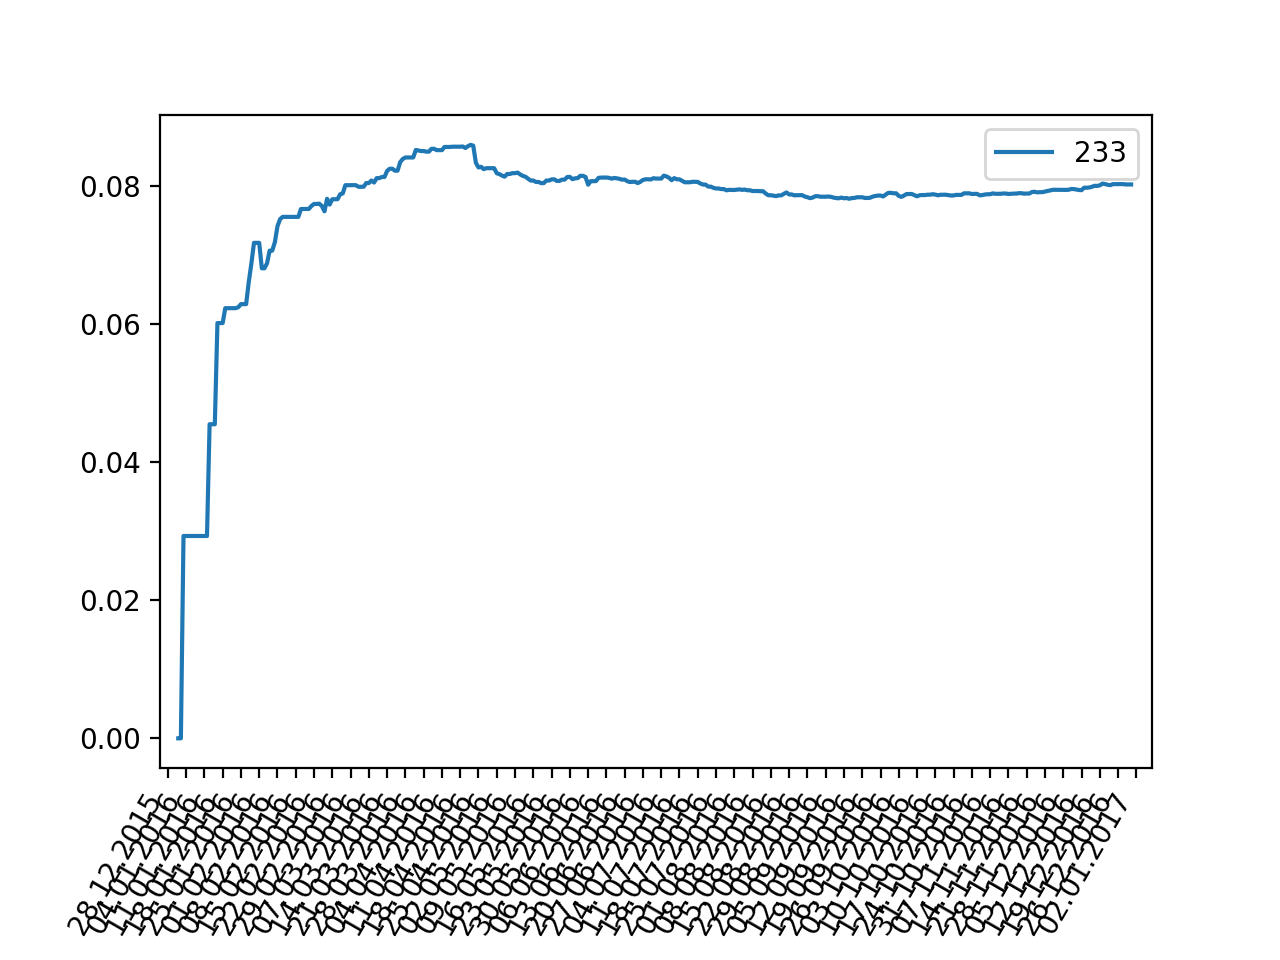

cluster: 233, 20 из 616 новостей:
	 В каких регионах России оказались самые суеверные водители
	 Поправки в ПДД запретят ездить без предупреждающих знаков
	 В Швеции водитель автобуса избил сирийца с криками «Ненавижу вас, свиньи»
	 ГИБДД отменит штраф, выписанный водителю за тень его машины
	 Мажоры превратили столичные улицы в гоночные трассы
	 Москвич рассказал, как его сбил автомобиль с номерами АМР
	 Медсестра без прав сбила насмерть коллегу, не дав сесть за руль пьяному хирургу
	 20-летний мажор на Infiniti сбил в Москве полицейского
	 Опубликовано видео погони полиции и ФСБ за кортежем бизнесмена Пригожина
	 На Урале машина протащила зацепившегося ребенка несколько километров
	 Очевидец произошедшего на Старом Арбате: Девушку избивали очень сильно
	 В Петербурге машина украинского консульства насмерть сбила пешехода
	 Появилось видео погони сотрудников ГИБДД за БТРом под Петербургом
	 Виновника ДТП на Mercedes с номерами 666 отчислили из академии правосудия
	 Мужчина на скутере 

In [22]:
for c_label, c_news in medium_clusters.items():
    compute_for_cluster(c_news, c_label)